In [145]:
%matplotlib inline

In [146]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
%autoreload 2

In [148]:
from pathlib import Path

from cycler import cycler

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches


from matplotlib import rcParams

import numpy as np
import pandas as pd


import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import geopandas as gpd

import intro_plots as ip

paper_path = Path('../paper/figures/')

slide_path = Path('../slides/figures/intro/')
proposal_path = Path('../draft/figures/intro/')
#rcParams['font.family'] = 'Segoe Print'

In [149]:
ny_all = pd.read_csv("nydata")

ny = ny_all[ny_all['NAME'].isin(ip.cdict.keys())].copy()

ny['DATES'] = pd.to_datetime(ny['DATE'])

In [150]:
nyjfk = ny[ny['NAME'].str.contains('JFK')].fillna(0)[['DATES', 'PRCPI', 'PRCP']]

In [151]:
nyjfk['PRCPI2'] = nyjfk['PRCPI']*10

<AxesSubplot:>

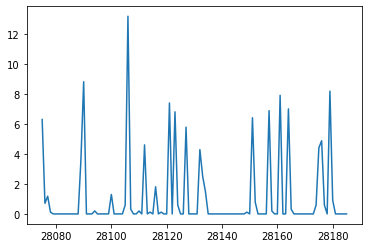

In [152]:
nyjfk['PRCPI2'].plot()

In [153]:
nyjfk['PRCPMM'] = nyjfk['PRCP']/10

In [154]:
dfs = nyjfk[(nyjfk['DATES']>'2021-02-04') & (nyjfk['DATES']<'2021-02-15')]
dfs

,DATES,PRCPI,PRCP,PRCPI2,PRCPMM
28110,2021-02-05,0.019685,5.0,0.19685,0.5
28111,2021-02-06,0.000000,0.0,0.00000,0.0
28112,2021-02-07,0.460629,117.0,4.60629,11.7
28113,2021-02-08,0.000000,0.0,0.00000,0.0
28114,2021-02-09,0.011811,3.0,0.11811,0.3
28115,2021-02-10,0.000000,0.0,0.00000,0.0
28116,2021-02-11,0.181102,46.0,1.81102,4.6
28117,2021-02-12,0.000000,0.0,0.00000,0.0
28118,2021-02-13,0.011811,3.0,0.11811,0.3
28119,2021-02-14,0.000000,0.0,0.00000,0.0


In [155]:
dfs['L1'] = dfs['PRCPMM'].apply(lambda x: f"{x:1.2f}") 
dfs['L2'] = dfs['PRCPI'].apply(lambda x: f"{x:1.4f}") 

<ipython-input-155-7439e98f7ff5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['L1'] = dfs['PRCPMM'].apply(lambda x: f"{x:1.2f}")
<ipython-input-155-7439e98f7ff5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['L2'] = dfs['PRCPI'].apply(lambda x: f"{x:1.4f}")


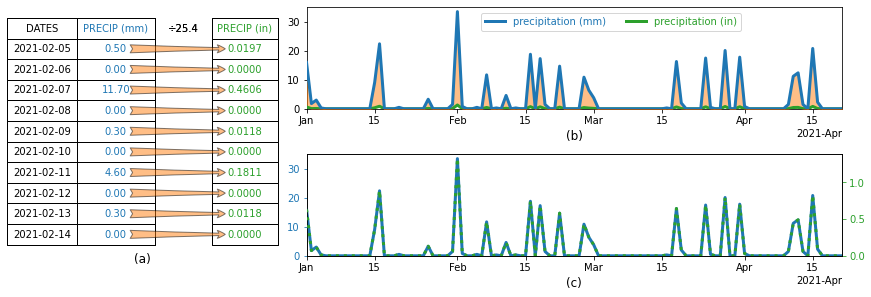

In [161]:
gridspec_kw={'height_ratios':[1,3]}
fig, axd = plt.subplot_mosaic([['table','time'], ['table', 'twin']],
                              constrained_layout=True, 
                              gridspec_kw={'width_ratios':[1,2]},
                              figsize=(12,4))
#gridspec_kw={'width_ratios':}

ocolor = 'tab:blue'
scolor = 'tab:green'
gcolor = 'tab:orange'
table = ip.plot_table(axd['table'], dfs[['DATES', 'L1', 'PRCPI', 'L2']], ['k', ocolor, 'white', scolor], textcolor=None)
#table_2 = ip.plot_table(axd['tab2'], dfs[['L2']], [scolor], textcolor=None)
fig.canvas.draw()
table[(0,1)].get_text().set_text('PRECIP (mm)')
table[(0,3)].get_text().set_text('PRECIP (in)')

axt = axd['twin'].twinx()
for n in ['time', 'twin']:
    axd[n].plot('DATES', 'PRCPMM', data=nyjfk, color=ocolor, zorder=10, lw=3, label='precipitation (mm)')
for ax, ls in [(axd['time'], '-'), (axt, ':')]:
    ax.plot('DATES', 'PRCPI', data=nyjfk, color=scolor, zorder=9, lw=3, label='precipitation (in)', 
            linestyle=ls)

for ax in [axt, axd['twin'], axd['time']]:
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator()))
    ax.set_xlim(nyjfk['DATES'].min(), nyjfk['DATES'].max())
    ax.set_ylim(0)


galpha = .5

axd['time'].fill_between('DATES','PRCPI', 'PRCPMM', data=nyjfk, color=gcolor, alpha=galpha, zorder=5)

table[0,2].visible_edges = 'vertical'
table[0,2].get_text().set_text("÷25.4") #25.4#÷10 * 0.039370
table[0,2].get_text().set_color('black')
for i in range(1,len(dfs)+1):
    table[i,2].visible_edges = 'vertical'
    x1, y1 = ip.source_cell(table[i,1], ocolor, xr=.55)
    x2, y2 = ip.source_cell(table[i,3], scolor, xr=.65)
    
    arrow = mpatches.ConnectionPatch(xyA=(x1, y1), coordsA=axd['table'].transData,
                                     xyB=(x2, y2), coordsB=axd['table'].transData,   
                                     arrowstyle="fancy", mutation_scale=20, 
                                     facecolor=gcolor, edgecolor='black', alpha=galpha)
    fig.add_artist(arrow)


axd['time'].xaxis.set_label_position('bottom')
axd['time'].yaxis.set_label_position('right')
axd['time'].set_xlabel("(b)", fontsize='large')
axd['twin'].set_xlabel("(c)", fontsize='large')
axd['table'].set_title("(a)", y=-.05, fontsize='large')
axd['twin'].tick_params('y', color=ocolor, labelcolor=ocolor)
axt.tick_params('y', color=scolor, labelcolor=scolor)
axd['time'].legend(ncol=2, bbox_to_anchor=(.82, .99), labelcolor='linecolor')
fig.savefig(proposal_path/"equivariant.png", dpi = 200)

<AxesSubplot:>

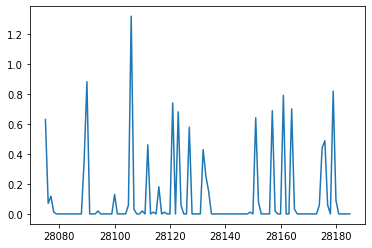

In [157]:
(nyjfk['PRCP']/10/25.4).plot()